# 2024-12-30: New Year, New Curve - Relative Value to Jumpstart 2025

Initiate a 2y fwd 1s2s15s PC1 hedged belly payer position (fly weights: -0.92, 2, -1.54) at -199.868 bps. ~2 week holding period. Base case: -187.778 bps, Bull case: -176.685 bps, Stop-loss: -198.872 bps, 1M Carry and Roll: -1.065426 bps, 3M Carry and Roll: -3.341693 bps

In the Dec FOMC press conference, Chair Powell mentioned that "we still have some work to do on inflation" and that it "may take a year or two to get to 2%" inflation, suggesting a potentially slower path of easing. In the SEP, the YE25 median dot rose by 50bp to 3.875%, and the YE26 median dot increased by 26 bp to 3.375%. What does this mean for the yield curve? In the near term, with the Fed close to being on hold, providing a front loaded cutting cycle, and an options markets showing much less policy uncertainty, these condition provide an environment favorable for relative value trades. Furthermore, given how little easing is priced in, bullish and/or yield curve normalization trade may be at attractive levels.

A specific strucuture that targets "pure" relative value in the swaps market is a belly paying 2y fwd 1s2s15s with hedge ratios derived from eliminating directional exposure i.e. the first principal component. We show below that running PCA on a 60 day rolling window on the EOD levels of individual spot and forward curves on the past year show significant relative value opportunities in swap space.

Below is a grid of z-scores of the PCA residuals from the analysis described above. And tables of the most "mispriced" curve and fly structures across swap space based on Z-scores of the previously described PCA residuals. 

In [1]:
import sys
sys.path.append("../")

In [2]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.utils.pca_utils import calc_pca_loadings_matrix
from CurvyCUSIPs.utils.regression_utils import (
        run_basic_linear_regression_df, 
        run_multiple_linear_regression_df, 
        plot_residuals_timeseries,
        modified_partial_regression_fly_plot
)

from datetime import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (15, 9),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

import plotly
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

In [3]:
curve_data_fetcher = CurveDataFetcher(fred_api_key=config["FRED_API_KEY"])

In [7]:
sofr_ois = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois")
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

In [8]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 12, 3)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [9]:
fwd_tenors = ["1M", "3M", "6M", "9M", "12M", "18M", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y"]
fwd_grid_dict, ql_curves = sofr_ois.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 482/482 [00:02<00:00, 170.27it/s]


In [ ]:
pca_results = sofr_ois.pca_on_fwd_grids(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 30),
    fwd_grid_dict=fwd_grid_dict, 
    rm_swap_tenors=["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "7M", "8M", "9M", "10M", "11M"],
    indy_fwd_strips=True,
    rolling_window=60,
    n_jobs_child=1,
    n_jobs_parent=6,
)

CLEANING UP ROLLING PCA RESULTS...: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


In [153]:
df = pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2024, 12, 30)]
df.style.background_gradient(cmap="RdYlGn", axis=0)

**Figure 1:** PCA Residual Z-Score Grid 

In [174]:
most_mispriced_dict = sofr_ois.most_mispriced_pca_resid_zscores(df, top_n=10)
display(most_mispriced_dict["curve"])
display(most_mispriced_dict["fly"])

Forward Tenor1 Tenor2  ZScore-Spread      Trade              Full Tenor
0   2Y Fwd     2Y    15Y      -5.131929  flattener    2Y Fwd 2Y-2Y Fwd 15Y
1   2Y Fwd    18M    15Y      -5.111687  flattener   2Y Fwd 18M-2Y Fwd 15Y
2   3Y Fwd     8Y    15Y      -4.973689  flattener    3Y Fwd 8Y-3Y Fwd 15Y
3   2Y Fwd     2Y     4Y      -4.823850  flattener     2Y Fwd 2Y-2Y Fwd 4Y
4   2Y Fwd    18M     4Y      -4.803609  flattener    2Y Fwd 18M-2Y Fwd 4Y
5   3Y Fwd     8Y    20Y      -4.760156  flattener    3Y Fwd 8Y-3Y Fwd 20Y
6   3Y Fwd     7Y    15Y      -4.753174  flattener    3Y Fwd 7Y-3Y Fwd 15Y
7  18M Fwd     2Y    15Y      -4.655103  flattener  18M Fwd 2Y-18M Fwd 15Y
8  18M Fwd     3Y    15Y      -4.606501  flattener  18M Fwd 3Y-18M Fwd 15Y
9   2Y Fwd     2Y    20Y      -4.603207  flattener    2Y Fwd 2Y-2Y Fwd 20Y

Forward ShortWing Belly LongWing  ZScore-Spread      Trade  \
0  2Y Fwd       12M    2Y      15Y      -9.724742  pay belly   
1  2Y Fwd       12M   18M      15Y      -9.684260  pay belly   
2  3Y Fwd        8Y   15Y      40Y       9.464136  rec belly   
3  2Y Fwd       12M    2Y       4Y      -9.416664  pay belly   
4  3Y Fwd        8Y   15Y      50Y       9.401372  rec belly   
5  2Y Fwd       12M   18M       4Y      -9.376181  pay belly   
6  3Y Fwd        3Y    8Y      15Y      -9.319090  pay belly   
7  2Y Fwd        2Y   15Y      40Y       9.293099  rec belly   
8  2Y Fwd       18M   15Y      40Y       9.272857  rec belly   
9  3Y Fwd        7Y   15Y      40Y       9.243621  rec belly   

                         Full Tenor  
0   2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y  
1  2Y Fwd 12M-2Y Fwd 18M-2Y Fwd 15Y  
2   3Y Fwd 8Y-3Y Fwd 15Y-3Y Fwd 40Y  
3    2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 4Y  
4   3Y Fwd 8Y-3Y Fwd 15Y-3Y Fwd 50Y  
5   2Y Fwd 12M-2Y Fwd 18M-2Y Fwd 4Y  
6    3Y Fwd 3Y-3Y Fwd 8Y-3Y Fwd 15Y  
7   2Y Fwd 2Y-2Y Fwd 15Y-2Y Fwd 40Y  
8  2Y Fwd 18M-2Y Fwd 15Y-2Y Fwd 40Y  
9   3Y Fwd 7Y-3Y Fwd 15Y-3Y Fwd 40Y

**Figure 2:** Stack ranked ZScore-Spreads for curve and fly structures

The 2Y and 3Y Fwd curves seem like the most "mispriced", solely based off our PCA model. This could be do to the fact that we have seen the market flip-flop after the Dec FOMC meeting. A hawkish policy guidance helped to produce a bear flattening move in the swap yield curve which reversed course later that week. OIS forwards are higher and flatter. Furthermore, with a holiday auction last week, I'd say the majority of mispricings can be explained by year-end stuff. I'm taking the easy way out b/c I don't really know.


In [175]:
dt1 = datetime(2024, 1, 2)
dt2 = datetime(2024, 12, 30)

sofr_ois.fwd_grid_dict_curve_plotter(
    tenor_date_pairs=[("Spot", dt1), ("2Y Fwd", dt1), ("3Y Fwd", dt1), ("Spot", dt2), ("2Y Fwd", dt2), ("3Y Fwd", dt2)], fwd_grid_dict=fwd_grid_dict, use_plotly=True
)

**Figure 3:** SOFR OIS Spot, 2Y Fwd, 3Y Fwd Curves from 2024-01-02 and 2024-12-30

According to our screener, paying the belly in a 2Y Fwd 1s2s15s is the most attractive based on PCA residual z-scores. Note we're using basic fly weights right now: [1, 2, 1]. Let's see the timeseries:

In [10]:
short_wing = "2Y Fwd 12M"
belly = "2Y Fwd 2Y"
long_wing = "2Y Fwd 15Y"
wing_curve = "2Y Fwd 12M-2Y Fwd 15Y"
fly = "2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y"

In [11]:
sofr_ois.fwd_grid_dict_timeseries_plotter(
    fwd_grid_dict=fwd_grid_dict, 
    tenors_to_plot=[short_wing, belly, long_wing],
    tenors_to_plot_on_secondary_axis=[wing_curve, fly],
    bdates=bdates,
    use_plotly=True 
)

PLOTTING SWAPS: 100%|██████████| 482/482 [00:00<00:00, 745.96it/s]


**Figure 4:** Timeseries of 2Y Fwd 12M, 2Y Fwd 2Y, 2Y Fwd 15Y (lhs) and 2Y Fwd 1s15s and 2Y Fwd 1s2s15s (rhs)

In [12]:
sofr_ois.pca_residual_timeseries_plotter(
    pca_results=pca_results, tenors_to_plot=[fly], key="rich_cheap_residual_zscore_timeseries_dict", use_plotly=True
)

NameError: name 'pca_results' is not defined

**Figure 5:** Timeseries of 2Y Fwd 1s2s15s 60d Rolling PCA Residuals

From a outright yield standpoint, my intuition says that paying the belly in the 2Y Fwd 1s2s15s doesn't look the most attractive. Even with clear mean reverting residuals, I still need to put some makeup on this fly to make it attractive. Let's run some regression to see what's really going on.

In [13]:
timeseries_df = sofr_ois.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=[short_wing, belly, long_wing, wing_curve, fly],
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 1, 3),
    tenor_is_df_index=True,
    scale_curve=True,
    scale_fly=True,
    custom_fly_weights=[1, 2, 1]
)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 253/253 [00:00<00:00, 354.68it/s]


Date  2Y Fwd 12M  2Y Fwd 2Y  2Y Fwd 15Y  2Y Fwd 12M-2Y Fwd 15Y  \
0   2024-01-02    3.121935   3.122010    3.385416              26.348086   
1   2024-01-03    3.109007   3.117982    3.405200              29.619298   
2   2024-01-04    3.217962   3.221794    3.490572              27.260918   
3   2024-01-05    3.252875   3.259628    3.539373              28.649824   
4   2024-01-08    3.258582   3.272703    3.548440              28.985818   
..         ...         ...        ...         ...                    ...   
247 2024-12-27    3.986716   4.010543    4.095496              10.878035   
248 2024-12-30    3.905001   3.894893    4.036886              13.188512   
249 2024-12-31    3.933068   3.929940    4.046880              11.381132   
250 2025-01-02    3.903227   3.906943    4.057710              15.448354   
251 2025-01-03    3.967139   3.948390    4.069744              10.260458   

     2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y  
0                         -26.333239  
1                         -27.824366  
2                         -26.494605  
3                         -27.299176  
4                         -26.161539  
..                               ...  
247                        -6.112498  
248                       -15.210205  
249                       -12.006835  
250                       -14.705119  
251                       -14.010197  

[252 rows x 6 columns]

**Figure 6:** Timeseries Data of relevant rates 

Regressing the level of the fly on the level of the belly gives you a measure of historical relative curvature i.e. we'd expect the fly to be more/less concave (hump) given where the belly is trading. 

                                   OLS Regression Results                                  
Dep. Variable:     2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y   R-squared:                       0.867
Model:                                         OLS   Adj. R-squared:                  0.867
Method:                              Least Squares   F-statistic:                     1637.
Date:                             Sat, 04 Jan 2025   Prob (F-statistic):          1.02e-111
Time:                                     14:31:40   Log-Likelihood:                -640.75
No. Observations:                              252   AIC:                             1285.
Df Residuals:                                  250   BIC:                             1293.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

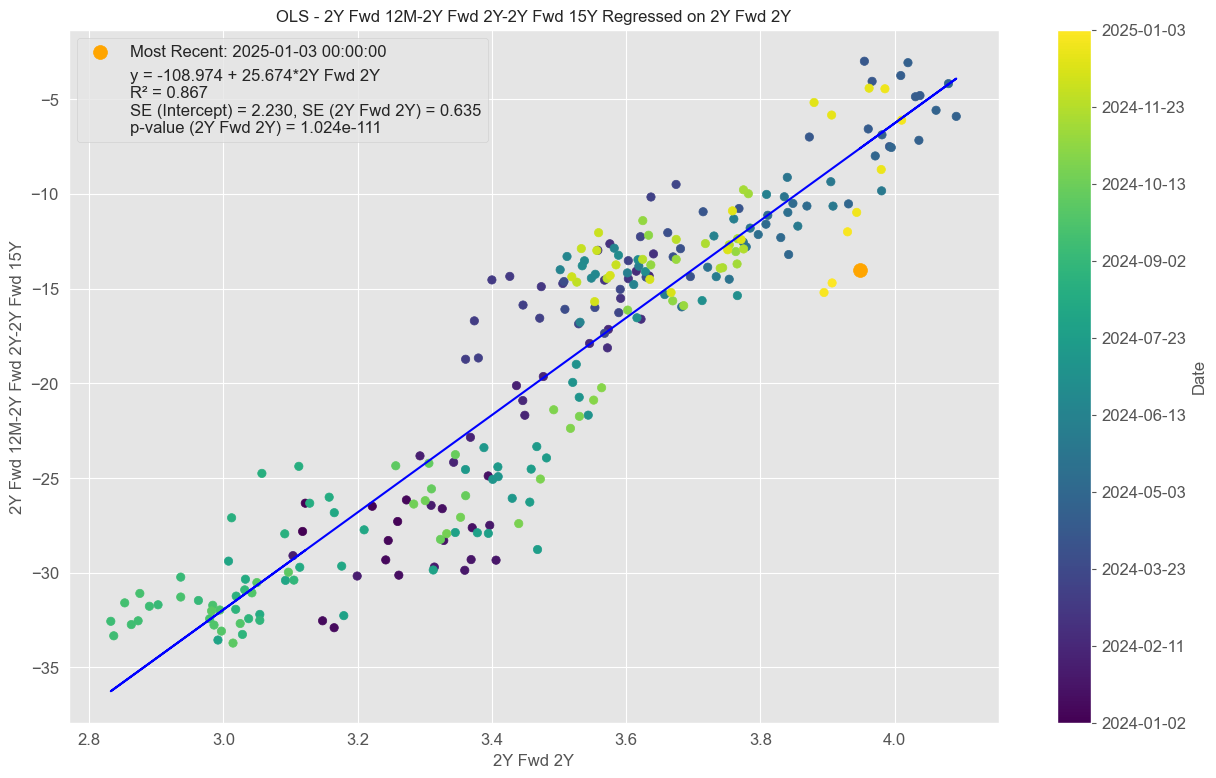

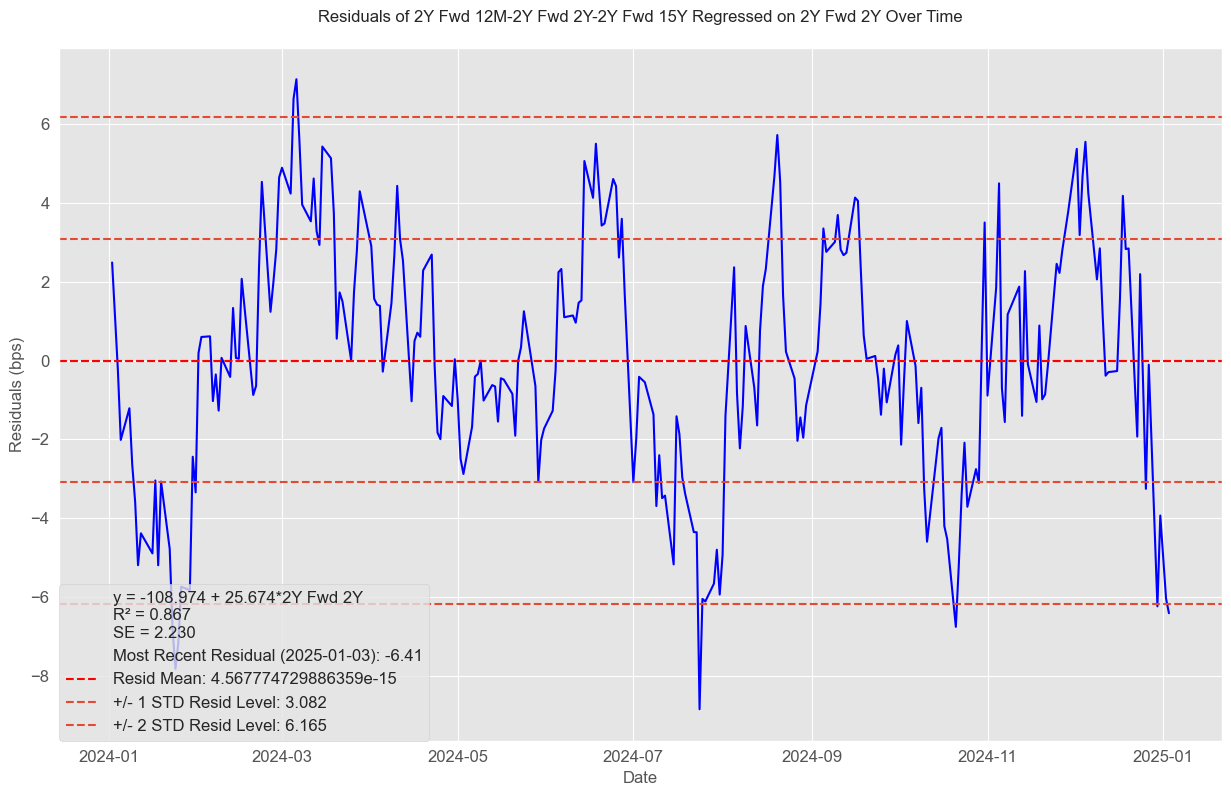

In [14]:
r = run_basic_linear_regression_df(
    df=timeseries_df,
    x_col=belly,
    y_col=fly,
    plot_most_recent=True,
    date_color_bar=True,
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])

**Figure 7:** Linear Regression Analysis Results of 2Y Fwd 1s2s15s vs. 2Y Fwd 2Y

The 1-2-1 weighted 1s2s15s has been well correlated to the directionality of the belly. Based off this historical relationship, we look a tad bit flat. The current residual is at -2 STDs, making a belly paying fly attractive even at the standard 1-2-1 weights. However, this confirms that the standard weighted fly is very exposured to the directionality of rates. It's New Years, we're not trying to take on that much risk. Good news is that we know how to structure a fly to hedge out the directionality: beta weighting this fly into a box trade is too boring so we'll use PCA again to derive our hedge weights. But first, we need to ask if we want to take a bet on solely PC3 or allow exposure to PC2 and PC3 given that our screener had the 2Y Fwd 2s15s as the most "mispriced" curve trade. This suggest that some of the mispricing in our fly is due to the slope of some of it's components. We can use multiple linear regression along with partial regression to show that only hedging PC1 is a better expression of true relative value in swap space.

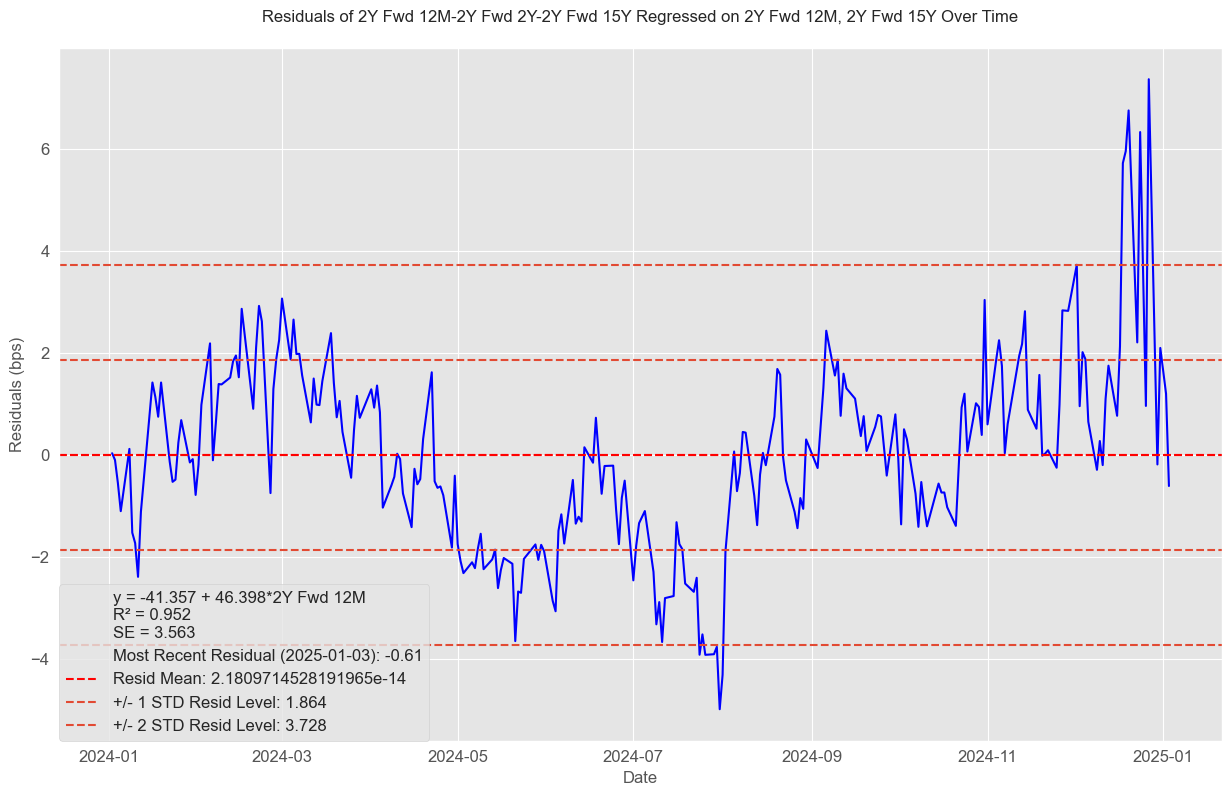

In [15]:
d, r = run_multiple_linear_regression_df(
    df=timeseries_df, x_cols=[short_wing, long_wing], y_col=fly, show_plot=False
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])

**Figure 8:** Timeseries of a Multiple Linear Regression of a 2Y Fwd 1s2s15s 1-2-1 Weighted Fly on 2Y Fwd 2Y and 2Y Fwd 1s15s.

When looking at the fly’s variation jointly explained by both 2Y Fwd 2Y and 2Y Fwd 12M–2Y Fwd 15Y, there is no large mispricing in either direction. It's current residual is near 0, so call it fair. On a two‐factor basis, the market’s pricing of the 2Y Fwd 1s2s15s fly is about what you would predict given its historical relationship to those two drivers. Does this mean our screener is incorrect? Not necessary!

We can't simply use the naive 1-2-1 weightings of the fly if we want a true expression of relative value. We need to dig deeper with partial regressions to see what our screener is picking up on. 

Note: We can also use the partial betas from the abobe MVLSR analysis to derive a hedge ratios.

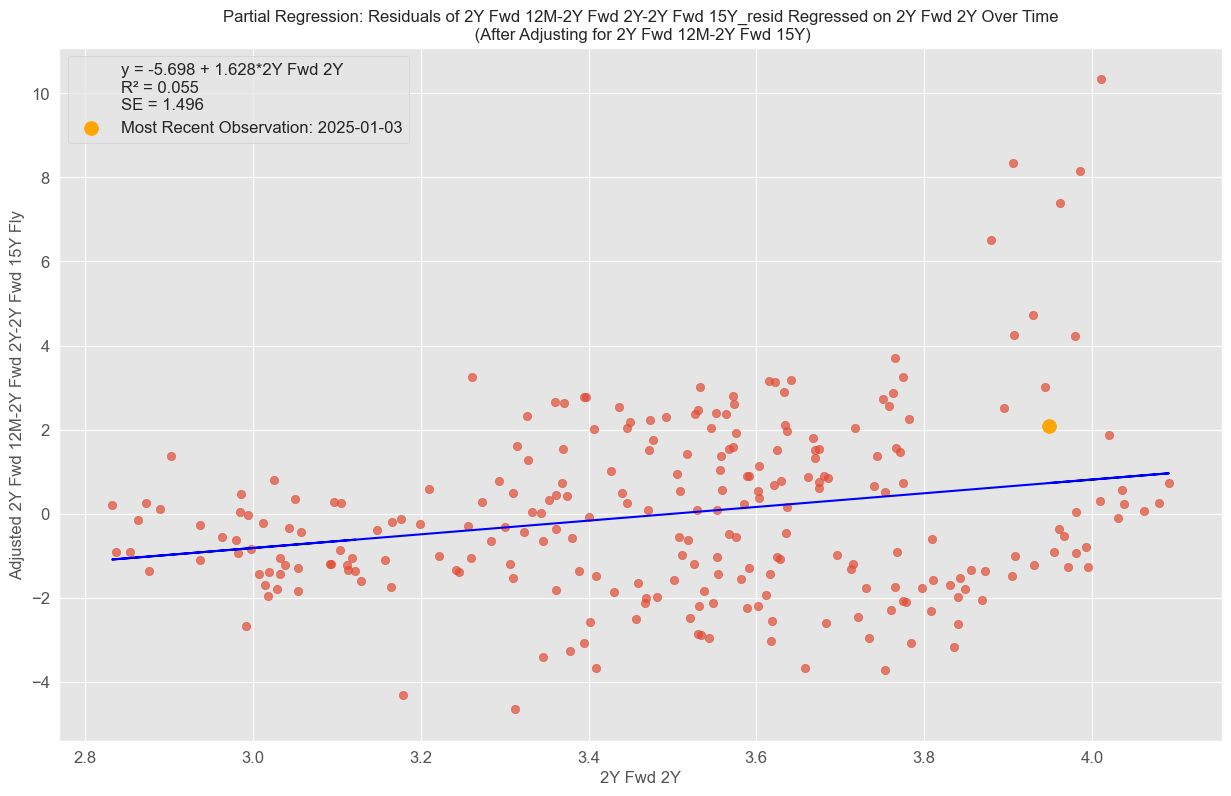

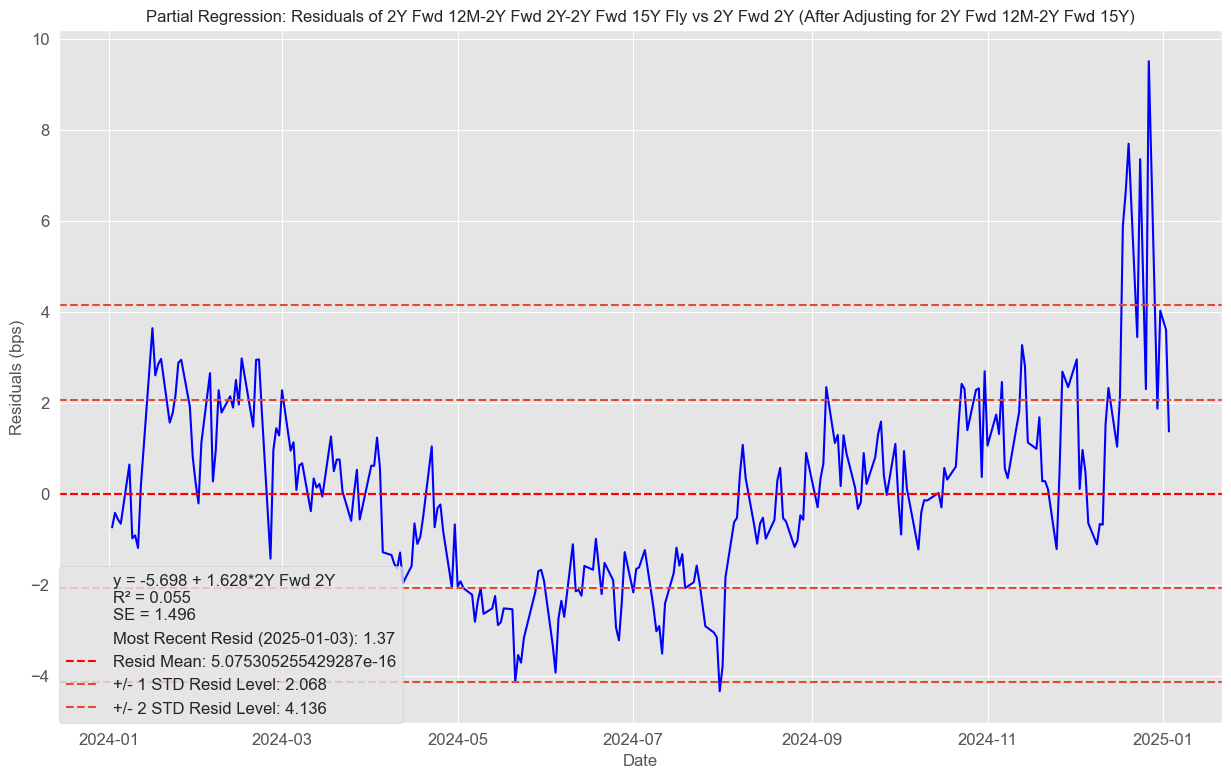

In [16]:
modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=[belly, wing_curve],
    y_col=fly,
    show_residual_timeseries=True,
    show_regression=True,
    stds=[1, 2],
)

**Figure 9:** Partial Regression Analysis Results of 2Y Fwd 1s2s15s 1-2-1 Weighted Fly on 2Y Fwd 2Y after adjusting for the level of 2Y Fwd 1s15s. 

See that the fly is actually expensive relative to the belly after adjusting to the slope of the wings.

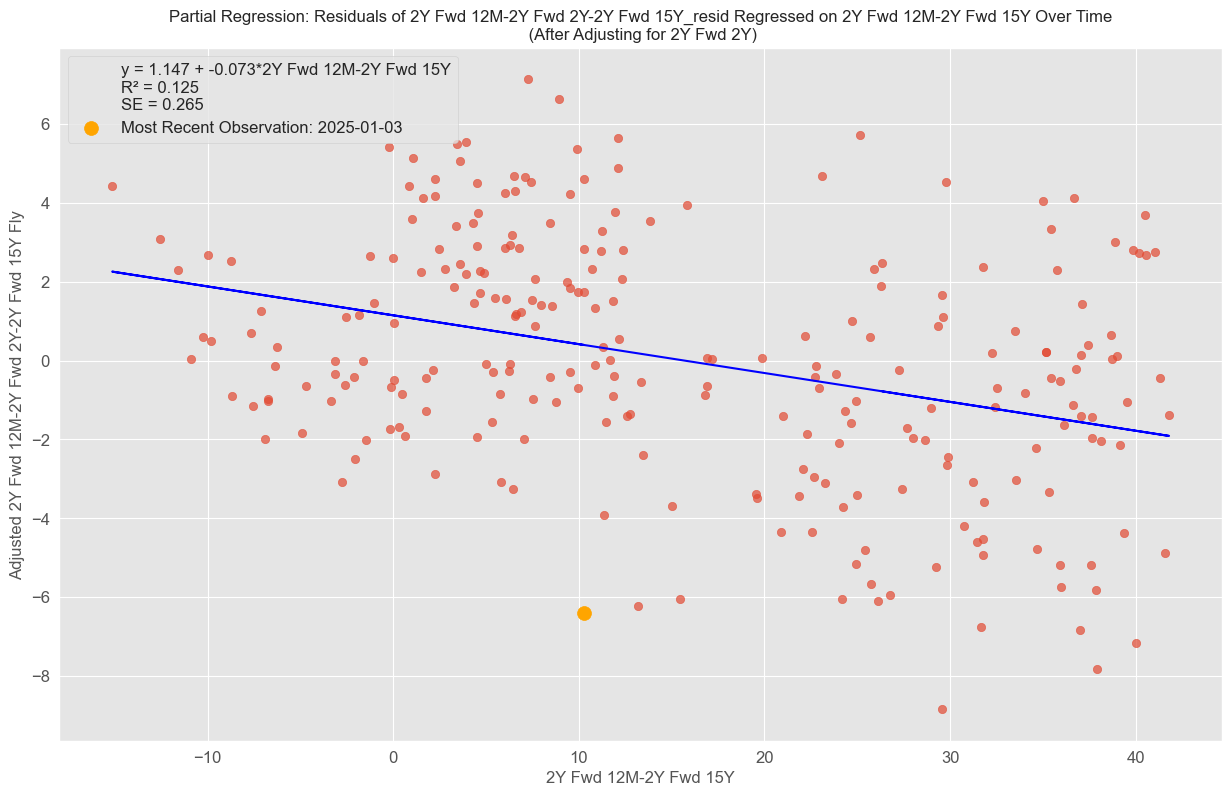

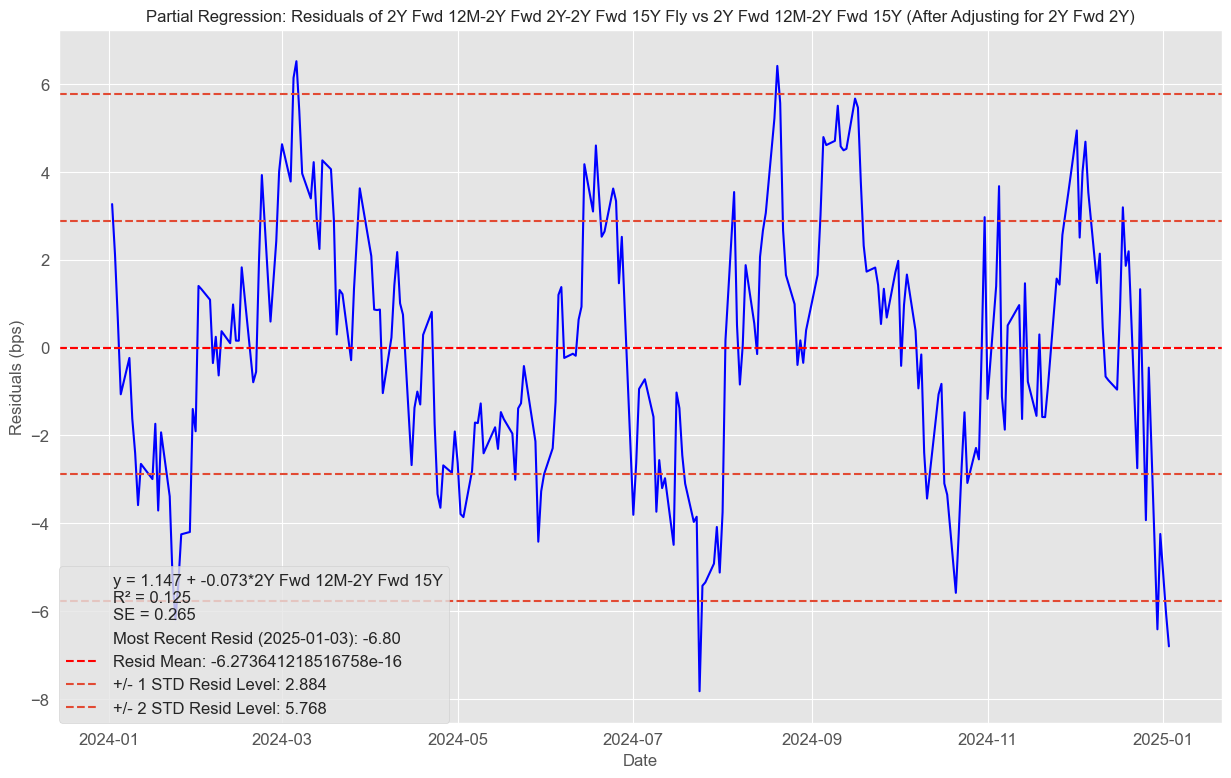

In [17]:
modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=[wing_curve, belly],
    y_col=fly,
    show_residual_timeseries=True,
    show_regression=True,
    stds=[1, 2],
)

**Figure 10:** Partial Regression Analysis Results of 2Y Fwd 1s2s15s 1-2-1 Weighted Fly on 2Y Fwd 1s15s after adjusting for the level of 2Y Fwd 2Y.

See that the fly is cheap relative to the slope of the wings after adjusting to the level of the belly. This suggests that it is attractive to also include PC2 exposure to a true relative value expression. Notice that these residuals are very similar to what we see in **Figure 7** without the direct exposure to the level of the belly, keeping the attractive mean reversion property of the resdiuals.

In [19]:
timeseries_df_copy = timeseries_df[timeseries_df['Date'] <= datetime(2024, 12, 31)]
pca_hedge_results = calc_pca_loadings_matrix(
    df=timeseries_df_copy[["Date", short_wing, belly, long_wing]].set_index("Date"),
    # run_on_level_changes=True,
    scale_loadings=True,
)

display(pca_hedge_results["loading_matrix"])

loadings = pca_hedge_results["loading_matrix"].values

pc1_hedge_weights = np.array([-1 / loadings[0, 0], 2 / loadings[1, 0], -1 / loadings[2, 0]])
scaled_pc1_hedge_weights = [2 * pc1_hedge_weights[0] / pc1_hedge_weights[1], 2, 2 * pc1_hedge_weights[2] / pc1_hedge_weights[1]]
print("PC1 Hedge Weights", scaled_pc1_hedge_weights)

pc1_pc2_hedge_weights = np.linalg.inv(
    np.array(
        [
            [loadings[0, 0], loadings[2, 0]],
            [loadings[0, 1], loadings[2, 1]],
        ]
    )
) @ np.array([loadings[1, 0], loadings[1, 1]])
scaled_pc1_pc2_hedge_weights = np.array([-2 * pc1_pc2_hedge_weights[0], 2, -2 * pc1_pc2_hedge_weights[1]])
print("PC1 & PC2 Hedge Weights", scaled_pc1_pc2_hedge_weights)


timeseries_df[f"{fly}_PC1_Hedged"] = (
    (scaled_pc1_hedge_weights[1] * timeseries_df[belly])
    + (scaled_pc1_hedge_weights[0] * timeseries_df[short_wing])
    + (scaled_pc1_hedge_weights[2] * timeseries_df[long_wing])
) * 100

timeseries_df[f"{fly}_PC1_PC2_Hedged"] = (
    (scaled_pc1_pc2_hedge_weights[1] * timeseries_df[belly])
    + (scaled_pc1_pc2_hedge_weights[0] * timeseries_df[short_wing])
    + (scaled_pc1_pc2_hedge_weights[2] * timeseries_df[long_wing])
) * 100

PC1       PC2       PC3
2Y Fwd 12M  0.333924 -0.022120 -0.004205
2Y Fwd 2Y   0.305950 -0.003351  0.005729
2Y Fwd 15Y  0.199305  0.042205 -0.001749

PC1 Hedge Weights [np.float64(-0.9162270323322016), 2, np.float64(-1.535084736293855)]
PC1 & PC2 Hedge Weights [-1.46801633  2.         -0.61059408]


What is the difference between solving for the weights that hedge out PC1 and PC2 moves vs directly using the loadings from PC3? Nothing!
- We isolated curvature exposure (driven by PC3)
- Movements driven by PC1 (level shifts) and PC2 (slope changes) have minimal impact on the P&L of the trade because PC3 is orthogonal to PC1 and PC2
- $\text{PC1} \times \text{PC2} \approx \text{PC3}$
    - the cross-product of two orthogonal vectors (PC1 and PC2) produces a third vector that is orthogonal to both! PC3!
    - PCs are orthogonal! 

In [20]:
pc3_loadings = loadings[:, 2]
pc3_normalized_weights = pc3_loadings / pc3_loadings[1]
scaled_pc3_hedge_weights = np.array([2 * pc3_normalized_weights[0], 2, 2 * pc3_normalized_weights[2]])
print("Explictly using PC3 loadings to derive Hedge Weights", scaled_pc3_hedge_weights)

print(
    "Confirmation that directly using PC3 loadings vs solving for hedged PC1 and PC2 moves is equivalent: ",
    np.linalg.norm(scaled_pc1_pc2_hedge_weights - scaled_pc3_hedge_weights) < 1e6,
)

Explictly using PC3 loadings to derive Hedge Weights [-1.46801633  2.         -0.61059408]
Confirmation that directly using PC3 loadings vs solving for hedged PC1 and PC2 moves is equivalent:  True


**Figure 11:** PCA Loadings Matrix with derived hedge weights

In [21]:
sofr_ois._general_df_plotter(
    df=timeseries_df,
    cols_to_plot=[fly],
    cols_to_plot_raxis=[f"{fly}_PC1_Hedged"],
    use_plotly=True
)

**Figure 12:** Timeseries Comparison of 2Y Fwd 1s2s15s 1-2-1 Weightings (lhs) and 2Y Fwd 1s2s15s PC1 hedged (rhs)

For people interested in a comparison of a truely PCA hedged fly (PC1 and PC2), 

In [22]:
sofr_ois._general_df_plotter(
    df=timeseries_df,
    cols_to_plot=[f"{fly}_PC1_Hedged"],
    cols_to_plot_raxis=[f"{fly}_PC1_PC2_Hedged"],
    use_plotly=True
)

**Figure 13:** Timeseries Comparison of 2Y Fwd 1s2s15s PC1 hedged (lhs) and 2Y Fwd 1s2s15s PC1 & PC2 hedged (rhs)

Visually, the mean reversion characteristics of the PC1 hedged fly is much more attractive. Notice that the PC1 & PC2 hedged fly resembles **Figure 9** which is expected.

To close out this note, we will run an Ornstein–Uhlenbeck (OU) process to simulate the expected path of the PC1 hedged fly. This note is not a primer the OU process - I frankly feel like I do not have the mathematical maturity to fully teach differential equations, but I'll give it a quick shot. The OU process is a stochastic differential equation (SDE) - an eqaution that models random behavior over (in many applied cases) time. OU process is a popular SDE for modeling mean-reverting variables since we can include parameters such as the speed of mean reversion, volatility (instantaneous), drift, and embed the Wiener process (pure random walk). We essentially can think of the OU process similar to how PCA allows us to decompose some high dimensional system into a few factors that are important. In the OU process, we can seperate the non-stochastic part which is the drift of the process and the stochastic part: the diffusion coefficient. Thus the drift coefficient can be interpreted as containing the non-stochastic, therefore predictable, driving forces of a trade, i.e. as a quantification of its return predictability. In contrast, the diffusion coefficient can be associated with the stochastic, unpredictable risk in a trade. Together, the SDE can be thought of as separating and connecting return and risk. I'd recommend [Schaller and Huggins' 
Fixed Income Relative Value Analysis: A Practitioners Guide to the Theory, Tools, and Trades](https://www.amazon.com/Fixed-Income-Relative-Analysis-Website-dp-1394189087/dp/1394189087/ref=dp_ob_title_bk)

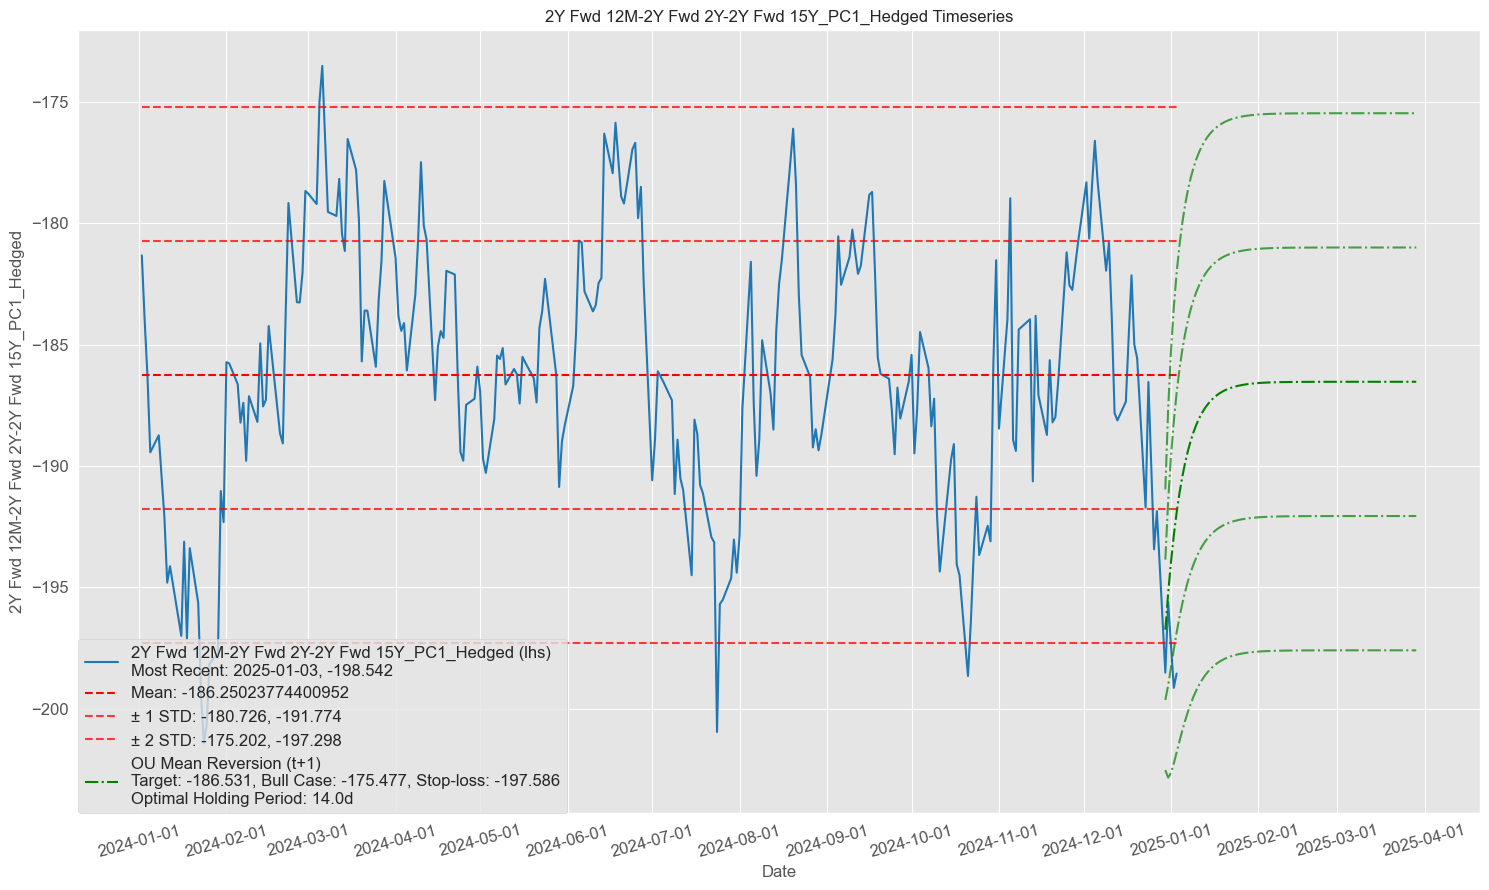

In [23]:
sofr_ois._general_df_plotter(
    df=timeseries_df,
    cols_to_plot=[f"{fly}_PC1_Hedged"],
    stds={f"{fly}_PC1_Hedged": [1, 2]},
    run_ou_mr_col_steps=(f"{fly}_PC1_Hedged", 90, datetime(2024, 12, 30)),
    show_2_sigma_ou_band=True,
    show_1_sigma_ou_band=True
)

**Figure 14:** Timeseries of 2Y Fwd 1s2s15s PC1 hedged and 90 day OU Process simulation with +/- 1, 2 sigma bands. Note take-profit and stop loss levels are based on 2 sigma band limits. 